<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Ensemble Learning. </center></h2>

In [12]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read Data

In [13]:
df_X = pd.read_csv('./data/x_train.csv', sep=';')
df_y = pd.read_csv('./data/y_train.csv', sep=';', header=None, names=['target'])

In [14]:
X = df_X.values
y = df_y['target'].values

In [15]:
print("X shape: ", X.shape)
X[:5]

X shape:  (25289, 12)


array([[3.90000000e+01, 1.00000000e+01, 3.00000000e+00, 1.70000000e+01,
        2.44444444e+01, 1.00000000e+00, 5.00000000e+00, 4.00000000e-01,
        2.65000000e+06, 1.37500000e+03, 2.10000000e+01, 2.00000000e+00],
       [2.10000000e+01, 2.20000000e+01, 1.90000000e+01, 5.50000000e+01,
        1.70454545e+01, 1.00000000e+00, 6.00000000e+00, 3.33333333e-01,
        5.61400000e+06, 3.82500000e+03, 5.10000000e+01, 4.00000000e+00],
       [5.00000000e+00, 6.00000000e+00, 1.00000000e+00, 6.00000000e+00,
        8.40000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        8.57000000e+05, 1.15000000e+03, 1.40000000e+01, 1.00000000e+00],
       [2.10000000e+01, 2.00000000e+00, 5.00000000e+00, 6.00000000e+00,
        1.90000000e+01, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.20000000e+05, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.00000000e+00, 5.00000000e+00, 1.00000000e+00, 5.00000000e+00,
        9.60000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00

In [16]:
print("y shape: ", y.shape)
y[:5]

y shape:  (25289,)


array([0, 1, 1, 1, 0])

# Train / Test Split

In [17]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5,    
                                                    random_state=123) 

# Task 1 (5 points)

Implement Random Forest classifier as it was described in your lectures:

**Input**: 
* training dataset $TDS=\{(x_{i},y_{i}),\,1=1,2,...N\}$; 
* the number of trees $B$ and the size of feature subsets $m$.

for $b=1,2,...B$:

1. generate random training dataset $TDS^{b}$ of size $N$ by sampling $(x_{i},y_{i})$ pairs from $TDS$ with replacement (bootstrap)
2. build a tree using $TDS^{b}$ training dataset with feature selection for each node from random subset of features of size $m$ (generated **individually for each node**).


**Output**: $B$ trees. Classification is done using majority vote and regression using averaging of $B$ outputs

**Hints:**
- Use decision tree classifier from sklean library. You can import it with the command: `from sklearn.tree import DecisionTreeClassifier` with `max_features` option. 
- You can use `numpy.random.choice()` function to generate random subsamples to train decition tree classifiers.

### Let' s start with small steps

#### First step

Implement auxiliary function, which generate K random subsamples (with replacement) of X, y of size N

In [18]:
def gen_subsamples(X, y, K, N, n_subset_features=5):
    samples = []
    features = []
    for i in range(K):
        index_sample = np.random.choice(len(X), N)
        featurs_sample_index = np.random.choice(X.shape[1], n_subset_features)
        X_sample = X[index_sample, :][:, featurs_sample_index]
        y_sample = y[index_sample]
        samples.append((X_sample,y_sample))
        features.append(featurs_sample_index)
    return samples, features

#### Second step

Implement auxiliary function which get list of (X,y) with lengh K and fit K base_estimators. Each estimator fit from the corresponding sample. 

In [19]:
def fit_subsamples(subsamples, base_estimator):
    trained = []
    for X, y in subsamples:
        model = base_estimator()
        model.fit(X,y)
        trained.append(model)
    return trained

#### Example with multiprocessing

In [20]:
def fit(params):    
    from sklearn.tree import DecisionTreeClassifier
    X, y, size = params
    subsamples, features = gen_subsamples(X, y, size, X.shape[0])
    return fit_subsamples(subsamples, DecisionTreeClassifier)

In [21]:
import multiprocessing

process_count = 4
parts = [
    (X, y, 1000 // process_count)
    for i in range(process_count)
]

In [22]:
with multiprocessing.Pool(process_count) as p:
    # every part is sent to separate processes
    clfs = p.map(fit, parts)

### And now combine it all together in one class

In [43]:
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
class RandomForestCalssifier(object):
    
    def __init__(self, n_trees=10, n_subset_features=2): # you can add more hyperparameters
        """
        This is your random forest classifier.
        
        Parameters
        ----------
        n_trees : int
            Number of decision trees to train.
        n_subset_features : int
            Number of random features to used to train a decision tree.
        """
        self.models = None
        self.base_estimator = DecisionTreeClassifier
        self.n_trees = n_trees
        self.n_subset_features = n_subset_features
        self.features_per_model = []
        
    def fit(self, X, y):
        """
        Fit the classifier.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        subsamples, self.features = gen_subsamples(X, y, self.n_trees,
                                    100, n_subset_features=self.n_subset_features)
        self.models = fit_subsamples(subsamples, DecisionTreeClassifier)    
    
    def predict_proba(self, X):
        """
        This methods performs probabilities prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        proba : numpy.array, shape = (n_objects, n_classes)
            Array with predicted probabilities. 
        """
        
        if self.models is None:
            return None
        result = []
        for index, model in enumerate(self.models):
#             print(model.predict_proba(X[:,self.features[index]])[0])
            result.append(model.predict_proba(X[:,self.features[index]])[:, 0])
#             return model.predict_proba(X[:,self.features[index]])
#         print(result)
        result = np.array(result)
#         print(result)
        proba = np.mean(result, axis=0)
#         return result
        return proba
    
    
    def predict(self, X):
        """
        This methods performs labels prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        labels : numpy.array, shape = (n_objects)
            1D array with predicted labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        if self.models is None:
            return None
        result = []
        for index, model in enumerate(self.models):
            result.append(model.predict(X[:,self.features[index]]))
        result = np.array(result)
        labels = []
        for i in range(X.shape[0]):
            labels.append(Counter(result[:, i]).most_common(1)[0][0])
        return np.array(labels)

In [44]:
clf = RandomForestCalssifier(n_trees=20, n_subset_features=12)
clf.fit(X_train, y_train)

In [45]:
y_test_predict = clf.predict(X_test)
y_test_predict_proba = clf.predict_proba(X_test)

# Task 2 (1 point)

Plot ROC curve on the test sample for your random forest classifier. Also, claculate ROC AUC value. Use `RandomForestClassifier.predict_proba()` method.

Hints:
- You can use `sklearn.metrics.roc_curve` frunction to calculate ROC curve.
- `sklearn.metrics.roc_auc_score` function helps you to calculate ROC AUC value.

In [46]:
# y_test_predict_proba

No handles with labels found to put in legend.


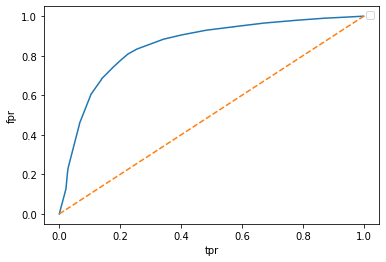

roc auc score:  0.7596920763320046


In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_test_predict_proba)
plt.plot(tpr, fpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.legend()
plt.show()
print('roc auc score: ', roc_auc_score(y_test, y_test_predict))

# Task 3 (2 points)

Plot dependecy of ROC AUC value from number of trees (`n_trees`) in your random forest classifier.

No handles with labels found to put in legend.


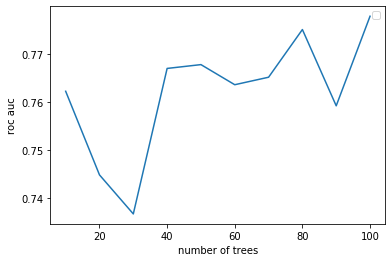

In [48]:
trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
res = []
for number_of_trees in trees:
    clf = RandomForestCalssifier(n_trees=number_of_trees, n_subset_features=12)
    clf.fit(X_train, y_train)
    y_test_predict = clf.predict(X_test)
    y_test_predict_proba = clf.predict_proba(X_test)
    res.append(roc_auc_score(y_test, y_test_predict))
plt.plot(trees, res)
plt.xlabel('number of trees')
plt.ylabel('roc auc')
plt.legend()
plt.show()

# Task 4 (2 points)

Plot dependecy of ROC AUC value from `n_subset_features` of your random forest classifier. Use `n_trees=100`.

No handles with labels found to put in legend.


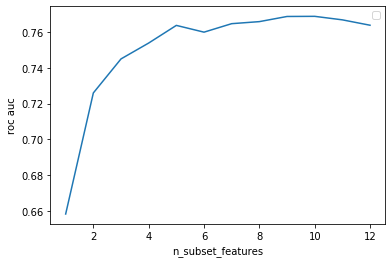

In [49]:
n_subset_features = [1,2,3,4,5,6,7,8,9,10,11,12]
res = []
for n_subset_feature in n_subset_features:
    clf = RandomForestCalssifier(n_trees=100, n_subset_features=n_subset_feature)
    clf.fit(X_train, y_train)
    y_test_predict = clf.predict(X_test)
    y_test_predict_proba = clf.predict_proba(X_test)
    res.append(roc_auc_score(y_test, y_test_predict))
plt.plot(n_subset_features, res)
plt.xlabel('n_subset_features')
plt.ylabel('roc auc')
plt.legend()
plt.show()